In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

/bin/bash: /home/hilbert/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-10-23 17:11:01--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1,36M  4,34MB/s    in 0,3s    

2023-10-23 17:11:02 (4,34 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text

In [10]:
df = pd.read_csv("housing.csv")
df = df[df.ocean_proximity.isin(["<1H OCEAN", "INLAND"])].reset_index(drop=True)
print(df.shape)

(15687, 10)


In [11]:
## preprocessing 

# fill empty values with 0
df = df.fillna(0)
df.median_house_value = np.log1p(df.median_house_value.values)

# train test split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# xtract target features
ytr = df_train.median_house_value.values
yvl = df_val.median_house_value.values
yts = df_test.median_house_value.values

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

# encode categorical features
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient="records")
xtr = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient="records")
xvl =  dv.fit_transform(val_dicts)

test_dicts = df_test.to_dict(orient="records")
xts =  dv.fit_transform(test_dicts)

## Q1

In [14]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(xtr, ytr)

DecisionTreeRegressor(max_depth=1)

In [16]:
export_text(dt)

'|--- feature_5 <= 0.50\n|   |--- value: [11.61]\n|--- feature_5 >  0.50\n|   |--- value: [12.30]\n'

In [39]:
print(dv.get_feature_names_out()[5])

ocean_proximity=<1H OCEAN


## Q2

In [23]:
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)

rf.fit(xtr, ytr)

print(mean_squared_error(yvl, rf.predict(xvl), squared=False))

0.244910835217013


## Q3

In [24]:
for n in range(10, 201, 10):
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=1,
        n_jobs=-1
    )

    rf.fit(xtr, ytr)
    rmse = mean_squared_error(yvl, rf.predict(xvl), squared=False)
    print("%4s -> %.3f" % (n, rmse))

  10 -> 0.245
  20 -> 0.238
  30 -> 0.236
  40 -> 0.235
  50 -> 0.234
  60 -> 0.234
  70 -> 0.234
  80 -> 0.234
  90 -> 0.234
 100 -> 0.234
 110 -> 0.234
 120 -> 0.234
 130 -> 0.234
 140 -> 0.234
 150 -> 0.233
 160 -> 0.233
 170 -> 0.233
 180 -> 0.234
 190 -> 0.234
 200 -> 0.234


## Q4

In [25]:
scores = []

for md in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=n,
            random_state=1,
            n_jobs=-1
        )

        rf.fit(xtr, ytr)
        rmse = mean_squared_error(yvl, rf.predict(xvl), squared=False)
        scores.append((md, n, rmse))

In [26]:
scores = pd.DataFrame(scores, columns=["max_depth", "n_estimators", "rmse"])
scores_pivot = scores.pivot(index="n_estimators", columns=["max_depth"], values=["rmse"])
scores_pivot

rmse                              
max_depth           10        15        20        25
n_estimators                                        
10            0.244911  0.244911  0.244911  0.244911
20            0.238384  0.238384  0.238384  0.238384
30            0.236135  0.236135  0.236135  0.236135
40            0.234671  0.234671  0.234671  0.234671
50            0.234439  0.234439  0.234439  0.234439
60            0.234023  0.234023  0.234023  0.234023
70            0.234013  0.234013  0.234013  0.234013
80            0.234311  0.234311  0.234311  0.234311
90            0.234290  0.234290  0.234290  0.234290
100           0.234178  0.234178  0.234178  0.234178
110           0.234210  0.234210  0.234210  0.234210
120           0.233923  0.233923  0.233923  0.233923
130           0.233786  0.233786  0.233786  0.233786
140           0.233618  0.233618  0.233618  0.233618
150           0.233496  0.233496  0.233496  0.233496
160           0.233334  0.233334  0.233334  0.233334
170           0.233321  0.233321  0.233321  0.233321
180           0.233569  0.233569  0.233569  0.233569
190           0.233847  0.233847  0.233847  0.233847
200           0.233812  0.233812  0.233812  0.233812

<Axes: xlabel='None-max_depth', ylabel='n_estimators'>

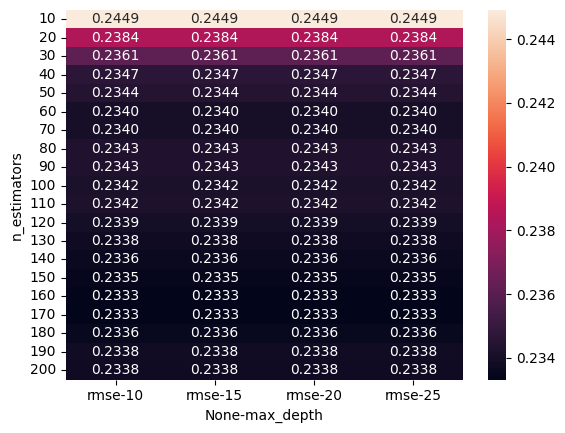

In [31]:
sns.heatmap(scores_pivot, annot=True, fmt=".4f")

In [33]:
scores.sort_values("rmse", ascending=False)[:3]

,max_depth,n_estimators,rmse
0,10,10,0.244911
60,25,10,0.244911
20,15,10,0.244911


## Q5

In [38]:
rf = RandomForestRegressor(
    n_estimators=n,
    random_state=1,
    n_jobs=-1
)

rf.fit(xtr, ytr)
fi_dict = dict(zip(dv.get_feature_names_out(), rf.feature_importances_))
fi_dict = {k:v for k,v in sorted(fi_dict.items(), key=lambda item: item[1], reverse=True)}
print(fi_dict)

{'median_income': 0.3366040592263974, 'ocean_proximity=<1H OCEAN': 0.23491497511984563, 'ocean_proximity=INLAND': 0.1293472246669439, 'latitude': 0.10046244942334147, 'longitude': 0.08674328735025284, 'housing_median_age': 0.03206353099823296, 'population': 0.027449384941579072, 'total_rooms': 0.021348736054347325, 'total_bedrooms': 0.016022496178079264, 'households': 0.015043856040980031}


## Q6

In [44]:
dtr = xgb.DMatrix(xtr, label=ytr)
dvl = xgb.DMatrix(xvl, label=yvl)

watchlist = [(dtr, 'train'), (dvl, 'valid')]

In [48]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtr,
    num_boost_round=200,
    verbose_eval=5,
    evals=watchlist,
)

In [53]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

df_score = parse_xgb_output(output)
df_score.sort_values("val_rmse", ascending=False)[:3]

,num_iter,train_rmse,val_rmse
0,0,8.07362,8.07348
1,5,1.38983,1.38852
2,10,0.33195,0.34802


In [61]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtr,
    num_boost_round=200,
    verbose_eval=5,
    evals=watchlist,
)

In [63]:
df_score = parse_xgb_output(output)
df_score.sort_values("val_rmse", ascending=False)[:3]

,num_iter,train_rmse,val_rmse
0,0,10.37456,10.37545
1,5,6.13433,6.13236
2,10,3.63299,3.62939
